# A neural network "from scratch" using numpy

This tutorial is adapted from the following article:

https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795

In [1]:
import numpy as np

## Architecture
Each layer will be defined by a number of inputs and outputs and an activation function.

In [2]:
nn_architecture = [
    {"input_dim": 2, "output_dim": 4, "activation": "relu"},
    {"input_dim": 4, "output_dim": 6, "activation": "relu"},
    {"input_dim": 6, "output_dim": 6, "activation": "relu"},
    {"input_dim": 6, "output_dim": 4, "activation": "relu"},
    {"input_dim": 4, "output_dim": 1, "activation": "sigmoid"},
]

## Initialization

First, the layers have to be initialized. This means we need to choose start values for the parameters. For the weights, this is most important since we need to "break the symmetry" - if all weights are the same the gradient will start at 0 and no optimization is possible.

Therefore the weights are typically initialized in some random way. Here we just use a scaled Gaussian random distribution.

In [3]:
def init_layers(nn_architecture, seed = 99):
    np.random.seed(seed)
    number_of_layers = len(nn_architecture)
    params_values = {}

    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1
        
    return params_values

## Activation functions

Next, we need to define the activation functions and the derivatives for the backward pass

In [4]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_derivative(Z):
    sig = sigmoid(Z)
    return sig * (1 - sig)

def relu_derivative(Z):
    dZ = (Z >= 0)
    return dZ

## Forward pass

The output vector $\mathbf{a}$ of each layer is calculated by

$\mathbf{a} = \sigma(\mathbf{z}) = \sigma(W \mathbf{a}_\mathrm{prev} + \mathbf{b})$

where $\mathbf{a}_\mathrm{prev}$ is the output vector of the previous layer (or the input vector in case of the first layer), $W$ is the weight matrix and $\mathbf{b}$ is the bias vector. The activation function $\sigma$ is applied component-wise.

In [5]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    Z_curr = np.matmul(W_curr, A_prev) + b_curr
    
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
        
    return activation_func(Z_curr), Z_curr

When propagating forward through the layers, we will keep the intermediate results in a memory dictionary which we can reuse later for calculating the backward pass

In [6]:
def full_forward_propagation(X, params_values, nn_architecture):
    memory = {}
    A_curr = X
    
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        A_prev = A_curr
        
        activ_function_curr = layer["activation"]
        W_curr = params_values["W" + str(layer_idx)]
        b_curr = params_values["b" + str(layer_idx)]
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    return A_curr, memory

## Loss

We will use this neural network for a classification task. The figure of merit to minimize is the binary cross entropy

\begin{equation}
L = -\frac{1}{m}\sum_{i=0}^{m} \left(y_i \ln \hat{y}_i + (1-y_i)\ln(1-\hat{y}_i)\right)
\end{equation}

With the vector of NN outputs $\mathbf{\hat{y}}$ and the vector of true labels $\mathbf{y}$ for $m$ training examples.

In [7]:
def get_loss_value(Y_hat, Y):
    return - np.mean(Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat))

The derivative w.r.t. the NN output $\hat{\mathbf{y}}$ is given by

\begin{equation}
\frac{\partial L}{\partial \hat{y}_i} = -\left(\frac{y_i}{\hat{y}_i}-\frac{1-y_i}{1-\hat{y}_i}\right)
\end{equation}

We leave out the $\frac{1}{m}$ here, since we will take the mean of the gradients for all training examples in the end

In [8]:
def get_loss_derivative(Y_hat, Y):
    return - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));

## Calculate the gradient - "Back propagation"

The gradient w.r.t. the parameters of all layers can be calculated by using the chain rule. We are "propagating back the errors on the Loss" through the network. Reminder: the output of each layer was given by

\begin{equation}
\mathbf{a} = \sigma(\mathbf{z}) = \sigma(W \mathbf{a}_\mathrm{prev} + \mathbf{b})
\end{equation}

The partial derivatives of the Loss w.r.t the weights, biases of a layer can be calculated starting from the partial derivatives w.r.t the output of the following layer $\frac{\partial L}{\partial \mathbf{a}}$ that was calculated previously.

\begin{align}
\frac{\partial L}{\partial \mathbf{z}} &= \frac{\partial L}{\partial \mathbf{a}}\circ \pmb{\sigma}'
\\
\frac{\partial L}{\partial W}
&= \frac{\partial L}{\partial \mathbf{z}} \cdot \mathbf{a}^T
\\
\frac{\partial L}{\partial \mathbf{b}} &= \frac{\partial L}{\partial \mathbf{z}}
\end{align}

To continue backwards to the previous layer we also need the partial derivatives w.r.t the output of the previous layer

\begin{equation}
\frac{\partial L}{\partial \mathbf{a}_\mathrm{prev}} = W^T \cdot \frac{\partial L}{\partial \mathbf{z}}
\end{equation}

The symbol "$\circ$" means element wise multiplication, the symbol "$\cdot$" matrix multiplication. Note the vectors and matrices in the equations above - these gradients are read like

\begin{align}
\frac{\partial L}{\partial W} & = 
\begin{pmatrix}
\frac{\partial L}{\partial w_{11}} & \frac{\partial L}{\partial w_{12}} & \cdots & \frac{\partial L}{\partial w_{1m}} \\
\frac{\partial L}{\partial w_{21}} & \frac{\partial L}{\partial w_{22}} & \cdots & \frac{\partial L}{\partial w_{2m}} \\
& \vdots &  & \\
\frac{\partial L}{\partial w_{n1}} & \frac{\partial L}{\partial w_{n2}} & \cdots & \frac{\partial L}{\partial w_{nm}}
\end{pmatrix}
\\
\frac{\partial L}{\partial\mathbf{a}} &=
\begin{pmatrix}
\frac{\partial L}{\partial a_1} \\
\frac{\partial L}{\partial a_2} \\
\vdots \\
\frac{\partial L}{\partial a_n} \\
\end{pmatrix}
\end{align}

Compare these result to what you would get when using the chain rule, just for single numbers (lets assume we have just one neuron in each layer):

\begin{align}
a &= \sigma(z) = \sigma(wa_\mathrm{prev} + b)
\\
\rightarrow \frac{\partial L}{\partial z} &= \frac{\partial L}{\partial a}\frac{\partial a}{\partial z} = \frac{\partial L}{\partial a} \sigma'
\\
\frac{\partial L}{\partial w} &= \frac{\partial L}{\partial z}\frac{\partial z}{\partial w} = \frac{\partial L}{\partial z} a
\\
\frac{\partial L}{\partial b} &= \frac{\partial L}{\partial z}\frac{\partial z}{\partial w} = \frac{\partial L}{\partial z}
\\
\frac{\partial L}{\partial a_\mathrm{prev}} &= \frac{\partial L}{\partial z}\frac{\partial z}{\partial w} = \frac{\partial L}{\partial z} w
\end{align}

So going to multiple neurons per layer essentially means replacing weights by the weight matrices and biases and outputs by the bias and output vectors (need to figure out how to transpose them correctly). In the implemntation below each output array has an additional dimension that corresponds to the index of the training example - that way we can efficiently calculate the gradient for all training examples at once.

In [9]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    
    if activation is "relu":
        derivative_activation_func = relu_derivative
    elif activation is "sigmoid":
        derivative_activation_func = sigmoid_derivative
    else:
        raise Exception('Non-supported activation function')
            
    dZ_curr = dA_curr * derivative_activation_func(Z_curr)
    dW_curr = np.matmul(
        dZ_curr,
        # need to transpose only the last 2 dimensions, 
        # since the first dimension is the training example index
        np.transpose(A_prev, (0, 2, 1))
    )
    db_curr = dZ_curr
    dA_prev = np.matmul(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

In [10]:
def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    
    dA_prev = get_loss_derivative(Y_hat, Y)
     
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx_curr = layer_idx_prev + 1
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = np.mean(dW_curr, axis=0)
        grads_values["db" + str(layer_idx_curr)] = np.mean(db_curr, axis=0)
    
    return grads_values

# Minimize the loss using Gradient descent

Since we now have the gradient w.r.t. all parameters we can follow the gradient to a potential minimum by successively subtracting it from the current parameter values. This introduces an Hyperparameter - the "learning rate" that corresponds to a step size we need to choose.

In [11]:
def update(params_values, grads_values, nn_architecture, learning_rate):
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values;

We calculate the gradient for all training examples for each optimization step (parameter update). One iteration over the whole training dataset is called one "epoch". In practice this is typically done in a stochastic way - called "Stochastic Grandient Descent" (**SGD**) where the gradient is evaluated on random subsets ("batches"), which typically leads to faster convergence since less iterations over the whole dataset are nescessary. For simplicity we stick here with calculating each gradient step for the full dataset.

In [12]:
def train(X, Y, nn_architecture, epochs, learning_rate):
    params_values = init_layers(nn_architecture, 2)
    loss_history = []
    
    # the operations assume
    # the outputs of the last layer to be a 1x1 matrix
    Y = Y.reshape(-1, 1, 1)
    
    for i in range(epochs):
        Y_hat, cashe = full_forward_propagation(X.reshape(list(X.shape)+[1]), params_values, nn_architecture)
        loss = get_loss_value(Y_hat, Y)
        loss_history.append(loss)
        
        grads_values = full_backward_propagation(Y_hat, Y, cashe, params_values, nn_architecture)
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
    return params_values, loss_history

# Run!

Lets try it out with a toy dataset of 2 "moons" in a 2-dimensional input feature space. Our goal is to learn which points in this space correspond to label 0 and 1.

In [13]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

In [14]:
X, y = make_moons(1000, noise=0.2)

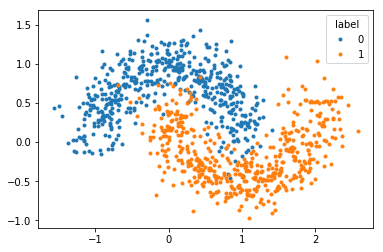

In [15]:
plt.plot(X[y==0][:,0], X[y==0][:,1], ".", label="0")
plt.plot(X[y==1][:,0], X[y==1][:,1], ".", label="1")
plt.legend(title="label")

Here, a 1-hidden-layer NN (2 layers in total) should be sufficient, but feel free to add more layers for experimentation!

In [16]:
nn_architecture = [
    {"input_dim": 2, "output_dim": 16, "activation": "relu"},
    {"input_dim": 16, "output_dim": 1, "activation": "sigmoid"},
]

In [17]:
params, loss_history = train(X, y, nn_architecture=nn_architecture, epochs=1000, learning_rate=1.)

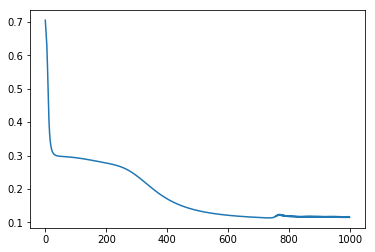

In [18]:
plt.plot(loss_history)

The minimization seems to have converged to some minimum. Lets visualize the NN output in the 2-dimensional input space!

In [19]:
# create a uniform grid of values around the training data
step = 0.1
grid = np.meshgrid(
    np.arange(X[:,0].min(), X[:,0].max()+step, step),
    np.arange(X[:,1].min(), X[:,1].max()+step, step)
)

In [20]:
# stack and reshape into an array which we can pass through the NN
xp = np.stack([grid[0].reshape(-1), grid[1].reshape(-1)], axis=1).reshape(-1, 2, 1)

In [21]:
# calculate the output - will be values betwenn 0 and 1 
scores, _ = full_forward_propagation(xp, params, nn_architecture)

In [22]:
def plot_data_and_scores(X, y, grid, scores):
    plt.contourf(grid[0], grid[1], scores.reshape(grid[0].shape), cmap="Spectral_r")
    plt.colorbar(label="NN output")
    plt.scatter(X[y==1][:,0], X[y==1][:,1], marker=".", edgecolors="black", color="red")
    plt.scatter(X[y==0][:,0], X[y==0][:,1], marker=".", edgecolors="black", color="blue")
    plt.xlim(grid[0].min(), grid[0].max())
    plt.ylim(grid[1].min(), grid[1].max())

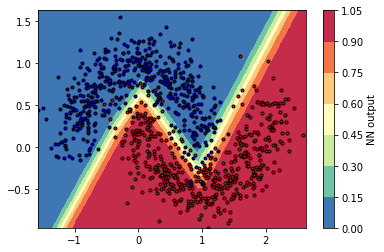

In [23]:
plot_data_and_scores(X, y, grid, scores)

# Cross check with scikit-learn

In [24]:
from sklearn.neural_network import MLPClassifier

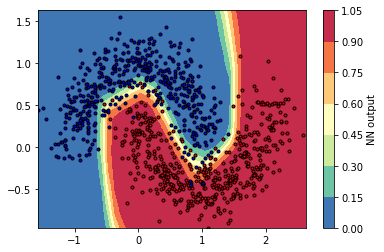

In [25]:
model_sklearn = MLPClassifier(learning_rate_init=0.1)
model_sklearn.fit(X, y)
plot_data_and_scores(X, y, grid, model_sklearn.predict_proba(xp.reshape(-1, 2))[:,1])

This was now a much more complex setup, due to the many default settings in sklearn. It used 100 neurons, a more sophisticated optimization algorithm, batch gradient descent and a regularization term.

In [26]:
model_sklearn

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.1, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

The following settings should match more or less what we tried to do manually

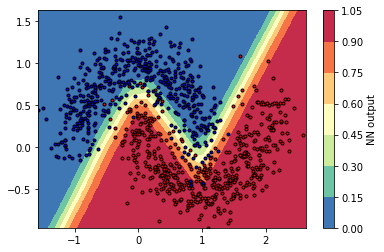

In [27]:
model_sklearn_simple = MLPClassifier(
    hidden_layer_sizes=(16,),
    learning_rate_init=1.,
    momentum=0.,
    alpha=0.,
    batch_size=len(X),
    solver="sgd",
    max_iter=1000,
    random_state=99
)
model_sklearn_simple.fit(X, y)
plot_data_and_scores(X, y, grid, model_sklearn_simple.predict_proba(xp.reshape(-1, 2))[:,1])